# Neurotoxicity Prediction Project

Problématique : Peut-on prédire la neurotoxicité potentielle d’un médicament à partir de ses caractéristiques moléculaires (fingerprints) et de ses cibles biologiques ?

Objectif : Développer un modèle de machine learning pour classer les médicaments en “neurotoxiques” vs “non neurotoxiques”, en utilisant des données ouvertes (SIDER, ChEMBL, PubChem).

# Context

* Neurological adverse effects (seizures, neuropathies, cognitive or psychiatric disorders) are often identified late (phase III trials or post-marketing). 

Sources : 

[Identification of potential drug-induced neuralgia signals via FAERS (Frontiers Pharmacology, 2025)](https://pubmed.ncbi.nlm.nih.gov/40808677/) 

 [Prediction of adverse drug reactions using demographic and non-clinical drug characteristics in FAERS (Scientific Reports, 2024)](https://www.nature.com/articles/s41598-024-74505-2)  




* A predictive model based on molecular descriptors and pharmacovigilance data could help anticipate neurotoxicity risks and reduce costly late-stage failures.

Sources : 

[Machine Learning for Toxicity Prediction Using Chemical Structures: Pillars for Success in the Real World (Seal, ACS Chem. Res. Tox., 2025)](https://pubs.acs.org/doi/10.1021/acs.chemrestox.5c00033)  

[Recent advances in AI-based toxicity prediction for drug discovery (Frontiers in Chemistry, 2025)](https://www.frontiersin.org/journals/chemistry/articles/10.3389/fchem.2025.1632046/full)  


[Integrating molecular fingerprints with ML for neurotoxicity prediction (2025)](https://journals.lww.com/atn/fulltext/2025/09000/integrating_molecular_fingerprints_with_machine.2.aspx)  



In [35]:
import os, sys, re, gzip, shutil, time, math, json, csv
import urllib.request
from time import sleep  
from pathlib import Path

import pandas as pd
import numpy as np

import requests
import requests_cache
from concurrent.futures import ThreadPoolExecutor, as_completed


import matplotlib.pyplot as plt

import requests

import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, DataStructs, inchi

from chembl_webresource_client.new_client import new_client

# Quick sanity print
print("Python:", sys.version.split()[0])
print("RDKit:", rdkit.__version__)
print("pandas:", pd.__version__, "numpy:", np.__version__)


Python: 3.11.13
RDKit: 2024.03.5
pandas: 2.2.2 numpy: 1.26.4


# Reproductibilité 

Création fichier "environment.yml" --> liste des librairies et dépendances pour recréer le même env à tt le monde 

# environment.yml

name: neurotox
channels:
  - conda-forge
dependencies:
  - python=3.11
  - rdkit=2024.03.5
  - pandas=2.2.2
  - numpy=1.26.4
  - scikit-learn=1.5.2
  - xgboost=2.1.1
  - lightgbm=4.5.0
  - matplotlib=3.9.2
  - shap=0.46.0
  - imbalanced-learn=0.12.3
  - pyyaml=6.0.2
  - pyarrow=17.0.0
  - jupyterlab=4.2.5
  - ipykernel=6.29.5
  - pip
  - pip:
      - chembl_webresource_client==0.10.9
      - pubchempy==1.0.4


# Data 

## 1) SIDER 


### Pourquoi SIDER ?

Pour prédire la neurotoxicité des médicaments, il nous faut une base de données fiable recensant les **effets indésirables (ADR = Adverse Drug Reaction)** déjà connus. 

La BD  **SIDER (Side Effect Resource)** est l’une des ressources publiques les plus utilisées en pharmacovigilance.  

Elle compile les effets secondaires mentionnés dans notices officielles des médicaments et les mappe vers la terminologie standardisée **MedDRA** (*Medical Dictionary for Regulatory Activities*).



### Contenu de SIDER
- **≈ 1 430 médicaments** couverts.  
- **≈ 5 868 effets indésirables distincts** (ADR).  
- **≈ 140 064 paires médicament↔ADR** 
- Données disponibles sous forme de tables :
  - `drug_names.tsv` → liste des médicaments et identifiants.  
  - `meddra.tsv` → mapping entre effets indésirables et codes MedDRA.  
  - `drug_adverse_effects.tsv` → paires *médicament ↔ ADR*.  


Dans ce projet, nous allons exploiter **SIDER** pour créer un **label binaire de neurotoxicité** :  

- `neurotoxic = 1` si un médicament est associé à au moins un ADR appartenant aux catégories MedDRA suivantes :  
  - **SOC Nervous system disorders**  --> SOC = System Organ Class (niveau le plus haut dans la hiérarchie de MedDRA) (tout ce qui touche directement le système nerveux central/périphérique).

  - ***SOC Psychiatric disorders** (hallucinations, dépression, agitation, etc. → effets neuropsychiatriques) --> Optionnel, si on a le temps*

- `neurotoxic = 0` sinon.

### Définition des labels de neurotoxicité

Dans MedDRA, chaque effet indésirable (ADR) est hiérarchisé en plusieurs niveaux :  

- **LLT (Lowest Level Term)** : terme très précis (ex. *Grand mal seizure*).  
- **PT (Preferred Term)** : regroupement plus large, standardisé (ex. *Seizure*).  
- **HLT/HLGT/SOC** : regroupements hiérarchiques plus larges (jusqu’au **SOC = System Organ Class**, ex. *Nervous system disorders*).  

Pour ce projet, nous définissons un médicament comme **neurotoxique** si au moins un ADR de type neurologique lui est associé.  
Deux stratégies sont envisagées :  

1. **Définition large** : tous les ADR du **SOC Nervous system disorders**.  
   - Avantage : couverture large.  
   - Limite : inclut aussi des ADR très fréquents et peu spécifiques comme *Headache* ou *Dizziness*, qui risquent de diluer le signal.  

2. **Définition stricte (PT forts)** : sélection d’un sous-ensemble de **Preferred Terms (PT)** indiscutablement neurotoxiques, par exemple :  
   *Seizure, Convulsion, Peripheral neuropathy, Tremor, Memory impairment, Cognitive disorder, Neuralgia, Ataxia.*  
   - Ces ADR sont considérés comme des **signaux robustes**, typiques de la neurotoxicité.  
   - Exemple : *Seizure* est un PT fort car il est directement lié à une atteinte neurologique sévère ;  
     *Headache* est au contraire trop fréquent et peu discriminant.  

👉 Cette approche permet d’obtenir deux définitions complémentaires du label :  
- Une version **SOC large** (plus sensible).  
- Une version **PT forts** (plus spécifique, moins bruitée).  

Ces deux définitions serviront à tester la robustesse des modèles de machine learning, conformément aux bonnes pratiques QSAR qui recommandent de soigner la qualité et la granularité des labels.

### Sources
- [SIDER: a public resource of drug side effects (Kuhn et al., Nucleic Acids Research, 2016)](https://academic.oup.com/nar/article/44/D1/D1075/2502602?login=false)  
- [Seal, 2025 — *Machine Learning for Toxicity Prediction Using Chemical Structures: Pillars for Success in the Real World* (ACS Chem. Res. Tox.)](https://pubs.acs.org/doi/10.1021/acs.chemrestox.5c00033) – importance d’un choix rigoureux des labels.  
- [Pang et al., 2025 — *NeuTox 2.0: hybrid deep learning for neurotoxicity screening* (Environment International)](https://www.sciencedirect.com/science/article/pii/S0160412024008316) – distinction entre signaux neurotoxiques forts (convulsions, neuropathies) et ADR bruités (céphalées, vertiges).  






Lien SIDER : http://sideeffects.embl.de/download/ 

Les fichiers fournis par **SIDER** n’ont pas de ligne d’entête : les colonnes sont décrites uniquement dans la documentation (README).  
Pour faciliter la manipulation et la compréhension des données, nous avons ajouté des noms de colonnes explicites, basés sur le schéma officiel. 

Fichiers : 

- **drug_names.tsv** --> Mapping entre l’ID interne SIDER/STITCH ↔ nom du médicament.

        Colonnes ajoutées : `stitch_id_flat`, `stitch_id_stereo`, `drug_name`.  



- **meddra_all_se.tsv.gz** --> table médicament ↔ effet secondaire indésirable (ADR).

C'est ce fichier qui va être filtré pour ne garder que les ADR neurologiques (SOC nervous system disorders).

1 (flat) et 2 (stereo) : STITCH compound id → identifiant chimique du médicament

3 : UMLS concept id → identifiant ADR

4 : MedDRA concept type (LLT/PT)

5 : UMLS concept id for MedDRA term

6 : Side effect name (ADR)

        Colonnes ajoutées : `stitch_id_flat`, `stitch_id_stereo`, `umls_id_raw`, `meddra_type`, `umls_id`, `side_effect_name`. 


- **meddra.tsv.gz**  → Le dictionnaire MedDRA avec correspondance LLT/PT

Colonnes : 

1 : UMLS concept id

2 : MedDRA id

3 : Kind of term (LLT/PT)

4 : ADR name

        Colonnes ajoutées : `umls_id`, `meddra_id`, `term_type`, `term_name`.  





In [36]:

# Créer dossier data si besoin
os.makedirs("data", exist_ok=True)

# URLs
url_drug_names    = "http://sideeffects.embl.de/media/download/drug_names.tsv"
url_meddra_all_se = "http://sideeffects.embl.de/media/download/meddra_all_se.tsv.gz"

# Chemins locaux compressés (gz)
path_drug_names       = "data/drug_names.tsv"
path_meddra_all_se_gz = "data/meddra_all_se.tsv.gz"

# Chemins locaux décompressés (sans .gz)
path_meddra_all_se = "data/meddra_all_se.tsv"

def download_if_missing(url, path):
    if not os.path.exists(path):
        print(f"Téléchargement {url} → {path}")
        urllib.request.urlretrieve(url, path)
    else:
        print(f"Déjà présent : {path}")

def gunzip_file(path_gz, path_out):
    if not os.path.exists(path_out):
        print(f"Décompression {path_gz} → {path_out}")
        with gzip.open(path_gz, "rb") as f_in, open(path_out, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
    else:
        print(f"Déjà décompressé : {path_out}")

# Téléchargement 
download_if_missing(url_drug_names, path_drug_names)
download_if_missing(url_meddra_all_se, path_meddra_all_se_gz)

# Décompression
gunzip_file(path_meddra_all_se_gz, path_meddra_all_se)

# Suppression des fichiers .gz
for gz_file in [path_meddra_all_se_gz]:
    if os.path.exists(gz_file):
        os.remove(gz_file)
        print(f"Supprimé : {gz_file}")

# Chargement 
drug_names = pd.read_csv(path_drug_names, sep="\t", header=None)
meddra_all_se = pd.read_csv(path_meddra_all_se, sep="\t", header=None)

# Renommer colonnes
if drug_names.shape[1] == 3:
    drug_names.columns = ["stitch_id_flat", "stitch_id_stereo", "drug_name"]
elif drug_names.shape[1] == 2:
    drug_names.columns = ["stitch_id", "drug_name"]

meddra_all_se.columns = [
    "stitch_id_flat","stitch_id_stereo","umls_id_raw","meddra_type","umls_id","side_effect_name"
]

# Réécriture des fichiers avec entête 
drug_names.to_csv("data/drug_names.tsv", sep="\t", index=False)
meddra_all_se.to_csv("data/meddra_all_se.tsv", sep="\t", index=False)

# Affichage 
print("\n=== drug_names.tsv ===")
print(drug_names.head())

print("\n=== meddra_all_se.tsv ===")
print(meddra_all_se.head())





Déjà présent : data/drug_names.tsv
Téléchargement http://sideeffects.embl.de/media/download/meddra_all_se.tsv.gz → data/meddra_all_se.tsv.gz
Déjà décompressé : data/meddra_all_se.tsv
Supprimé : data/meddra_all_se.tsv.gz

=== drug_names.tsv ===
   stitch_id  drug_name
0  stitch_id  drug_name
1  stitch_id  drug_name
2  stitch_id  drug_name
3  stitch_id  drug_name
4  stitch_id  drug_name

=== meddra_all_se.tsv ===
   stitch_id_flat  stitch_id_stereo  umls_id_raw  meddra_type  umls_id  \
0  stitch_id_flat  stitch_id_stereo  umls_id_raw  meddra_type  umls_id   
1  stitch_id_flat  stitch_id_stereo  umls_id_raw  meddra_type  umls_id   
2  stitch_id_flat  stitch_id_stereo  umls_id_raw  meddra_type  umls_id   
3  stitch_id_flat  stitch_id_stereo  umls_id_raw  meddra_type  umls_id   
4  stitch_id_flat  stitch_id_stereo  umls_id_raw  meddra_type  umls_id   

   side_effect_name  
0  side_effect_name  
1  side_effect_name  
2  side_effect_name  
3  side_effect_name  
4  side_effect_name  


In [37]:
# On garde uniquement les Preferred Terms (PT)
meddra_pt = meddra_all_se[meddra_all_se["meddra_type"] == "PT"].copy()

# Sauvegarde
pt_path = "data/meddra_all_se_PT.tsv"
meddra_pt.to_csv(pt_path, sep="\t", index=False)
print(f"Fichier sauvegardé : {pt_path}")

# Extraire tous les effets secondaires uniques 
side_effects = sorted(meddra_pt["side_effect_name"].unique().tolist())

print(f"\nNombre total d'effets secondaires uniques (PT) : {len(side_effects)}")

print(f"\nNombre total d'effets secondaires uniques (PT) : {len(side_effects)}")
print("Exemple des 20 premiers :", side_effects[:20])

Fichier sauvegardé : data/meddra_all_se_PT.tsv

Nombre total d'effets secondaires uniques (PT) : 4251

Nombre total d'effets secondaires uniques (PT) : 4251
Exemple des 20 premiers : ["5'nucleotidase increased", 'AIDS dementia complex', 'Abasia', 'Abdominal abscess', 'Abdominal adhesions', 'Abdominal discomfort', 'Abdominal distension', 'Abdominal hernia', 'Abdominal infection', 'Abdominal injury', 'Abdominal neoplasm', 'Abdominal pain', 'Abdominal pain lower', 'Abdominal pain upper', 'Abdominal rigidity', 'Abdominal sepsis', 'Abdominal strangulated hernia', 'Abdominal symptom', 'Abdominal tenderness', 'Abdominal wall abscess']


Bien que MedDRA soit hiérarchisé jusqu’au niveau SOC (System Organ Class), la version SIDER utilisée ne fournit que les termes LLT/PT.
Pour définir la neurotoxicité, nous avons donc filtré directement les PT contenant des mots-clés neurologiques (ex. seizure, neuropathy, tremor, ataxia), ce qui revient à approximer le SOC Nervous system disorders à partir des données disponibles.
Cette approche est cohérente avec la littérature récente en pharmacovigilance, où les labels de neurotoxicité reposent souvent sur une sélection manuelle de PT neurologiques forts, plutôt que sur la hiérarchie SOC complète.

Sources :

[Identification of potential drug-induced neuralgia signals through disproportionality analysis of the FAERS database](https://pubmed.ncbi.nlm.nih.gov/40808677/) 

[Integrating molecular fingerprints with ML for neurotoxicity prediction (2025)](https://journals.lww.com/atn/fulltext/2025/09000/integrating_molecular_fingerprints_with_machine.2.aspx)  

[Machine Learning for Toxicity Prediction Using Chemical Structures: Pillars for Success in the Real World (Seal, ACS Chem. Res. Tox., 2025)](https://pubs.acs.org/doi/10.1021/acs.chemrestox.5c00033) 


Fichier sauvegardé : data/meddra_all_se_PT.tsv

4251 PT uniques à trier sans SOC neuro --> on peut utiliser une approche par recherche de mots clés de PT forts : "convulsion", "ataxia", “neuropathy”, etc




Convulsions / Crises : seizure, convulsion, epilepsy, epileptic.

Neuropathies périphériques : neuropathy, neuralgia, polyneuropathy, paresthesia, hypoesthesia.

Troubles moteurs : tremor, ataxia, dystonia, parkinsonism, dyskinesia, rigidity.

Troubles cognitifs : memory impairment, amnesia, confusion, cognitive disorder, dementia-like.

Troubles psychiatriques liés (optionnel selon temps) : hallucination, psychosis, agitation, depression, anxiety (plutôt SOC Psychiatric disorders).

Autres symptômes neurologiques : dizziness, vertigo, syncope, headache (→ à discuter car fréquents mais peu spécifiques).

In [38]:


# Motifs regex pour identifier les PT neurologiques 
# "STRICT" = haute spécificité neuro (PT fort)
KEYWORDS_STRICT = {
    # Crises/convulsions/épilepsie
    "seizure_convulsion":  r"\bseizur|\bconvuls|\bepilep|grand\s*mal|petit\s*mal",
    # Neuropathies/paresthésies
    "neuropathy_neuralgia": r"\bneuro(?:pathy|pathies)\b|\bpolyneurop|\bperipheral\s+neuropathy|\bneuralg|\bpar(?:a|ae)sthes|\bhypo(?:a|e)sthes|\bhyper(?:a|e)sthes",
    # Troubles moteurs
    "motor_disorders":     r"\btremor|\btremulous|\bataxi|\bdystoni|\bdyskines|\bparkinson|\brigidi|\bakinesia|\bbradykinesia",
    # Cognitif/conscience
    "cognitive":           r"memory\s+impairment|\bamnesia|\bamnestic|\bcognit|cognitive\s+disorder|\bconfus|\bdelirium|\bdementia",
    # Autres neuro forts
    "coma_syncope":        r"\bcoma|\bsyncop|loss\s+of\s+consciousness",
    "myoclonus":           r"\bmyoclon",
    "encephalo_meningeal": r"\bencephalopath|\bencephaliti|\bmeningiti",
    "nystagmus":           r"\bnystagmus",
    "guillain_barre":      r"guillain[- ]?barr(?:e|é)",
}

# Ajout des symptômes plus fréquents/moins spécifiques --> broad 
KEYWORDS_BROAD = KEYWORDS_STRICT | {
    "dizziness_vertigo":   r"\bdizz|\bvertig|\boscillopsia",
    "headache_migraine":   r"\bheadache|\bmigraine|\bcluster\s+headache",
    "somnolence_insomnia": r"\bsomnol|\bdrows|\binsomni",
    "psychiatric_light":   r"\bhallucin|\bagitat|\bdepress|\banxiet|\banxious",
}

# choix du mode (PT fort/strict dans notre cas) 
USE_STRICT = True
PATTERNS = KEYWORDS_STRICT if USE_STRICT else KEYWORDS_BROAD

# Parse et compile les motifs regex
def compile_patterns(patterns: dict[str, str]) -> dict[str, re.Pattern]: # Insensible à la casse
    return {k: re.compile(v, flags=re.IGNORECASE) for k, v in patterns.items()}


# Retourne la liste des catégories dont le motif match le PT.
def match_categories(term: str, compiled: dict[str, re.Pattern]) -> list[str]: 
    return [cat for cat, rx in compiled.items() if rx.search(term)]

# Associe chaque catégorie à ses PT matchés + la liste de l’union de tous les PT neurologiques détectés
def collect_matches(pt_series: pd.Series, compiled: dict[str, re.Pattern]) -> tuple[dict[str, list[str]], list[str]]:
    hits = {cat: [] for cat in compiled}
    for se in pt_series:
        for cat, rx in compiled.items():
            if rx.search(se):
                hits[cat].append(se)
    # Nettoyage: unique + tri
    hits = {cat: sorted(set(lst), key=str.casefold) for cat, lst in hits.items()}
    union = sorted({pt for lst in hits.values() for pt in lst}, key=str.casefold)
    return hits, union

# On récupère la liste des PT (unique, nettoyés) depuis le df
assert "side_effect_name" in meddra_pt.columns, "La colonne 'side_effect_name' est absente de meddra_pt."
pt_series = (
    meddra_pt["side_effect_name"]
    .dropna()
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)  # normalise espaces
    .unique()
    .tolist()
)

# Matching 
compiled = compile_patterns(PATTERNS)
hits, neuro_pt_list = collect_matches(pt_series, compiled)

# Sauvegarde
out_dir = Path("data")
out_dir.mkdir(exist_ok=True)
list_path = out_dir / f"PT_neuro_{'STRICT' if USE_STRICT else 'BROAD'}.txt"
audit_path = out_dir / f"PT_neuro_{'STRICT' if USE_STRICT else 'BROAD'}_by_category.csv"
pd.Series(neuro_pt_list, name="side_effect_name").to_csv(list_path, index=False, header=False)

# Audit par catégorie (PT + catégories)
# On construit un tableau long: (category, side_effect_name)
audit_rows = [(cat, pt) for cat, lst in hits.items() for pt in lst]
audit_df = pd.DataFrame(audit_rows, columns=["category", "side_effect_name"])
audit_df.to_csv(audit_path, index=False)

# Affichage
print(f"PT uniques : {len(pt_series)}")
print(f"PT neurologiques :  {len(neuro_pt_list)}")
print(f"Fichiers générés : {list_path}  &  {audit_path}")

print("\nPT_neuro_STRICT_by_category.csv : ")
audit_loaded = pd.read_csv(audit_path)
print(audit_loaded.head(105))  





PT uniques : 4251
PT neurologiques :  103
Fichiers générés : data/PT_neuro_STRICT.txt  &  data/PT_neuro_STRICT_by_category.csv

PT_neuro_STRICT_by_category.csv : 
                category                              side_effect_name
0     seizure_convulsion                             Clonic convulsion
1     seizure_convulsion                      Complex partial seizures
2     seizure_convulsion                                    Convulsion
3     seizure_convulsion                           Convulsion neonatal
4     seizure_convulsion                   Drug withdrawal convulsions
..                   ...                                           ...
99   encephalo_meningeal                      Metabolic encephalopathy
100  encephalo_meningeal  Posterior reversible encephalopathy syndrome
101  encephalo_meningeal                          Toxic encephalopathy
102            nystagmus                                     Nystagmus
103       guillain_barre                       Guillain-

### Label binaire par médicament 

Objectif : neurotoxic = 1 si un médicament a  + d'un PT fort

Filtrer le DataFrame meddra_pt (SIDER) pour ne garder que les lignes dont le side_effect_name figure dans PT_neuro_STRICT.txt

Marquer chaque médicament (stitch_id_flat) comme neurotoxique s’il présente au moins un de ces PT forts



In [39]:

# Exclure les PT de type “… site reaction”
SITE_RX = re.compile(r"\b(application|injection|infusion)\s+site\b", flags=re.IGNORECASE)


# Charger la liste des PT forts et nettoyer
pt_path = Path("data/PT_neuro_STRICT.txt")
pt_strict = (
    pd.read_csv(pt_path, header=None, names=["pt"])
      .pt.astype(str).str.strip()
)
# exclure "site reactions" et blacklist explicite
pt_strict_clean = (
    pt_strict[~pt_strict.str.contains(SITE_RX)]
)
pt_strict_clean = set(pt_strict_clean)

print(f"PT forts bruts : {pt_strict.nunique()} | après nettoyage : {len(pt_strict_clean)}")

#  Harmoniser les IDs médicaments dans drug_names
if "stitch_id_flat" not in drug_names.columns:
    if "stitch_id" in drug_names.columns:
        drug_names = drug_names.rename(columns={"stitch_id": "stitch_id_flat"})
    else:
        raise KeyError("drug_names doit contenir 'stitch_id_flat' ou 'stitch_id'.")

all_drugs = (
    drug_names[["stitch_id_flat", "drug_name"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

# Sélectionner uniquement les lignes PT forts dans meddra_pt
required_cols = {"stitch_id_flat", "side_effect_name"}
missing = required_cols.difference(meddra_pt.columns)
if missing:
    raise KeyError(f"Colonnes manquantes dans meddra_pt: {missing}")

meddra_neuro = meddra_pt[
    meddra_pt["side_effect_name"].isin(pt_strict_clean)
].copy()

# Agrégation par médicament : on compte le nombre de PT forts par molécule
#    - n_neuro_pt = nb de PT forts distincts
#    - neurotoxic = 1 si n_neuro_pt >= 1
agg = (
    meddra_neuro.groupby("stitch_id_flat")["side_effect_name"]
    .nunique()
    .reset_index(name="n_neuro_pt")
)
agg["neurotoxic"] = (agg["n_neuro_pt"] >= 1).astype(int)

# Ajouter les médicaments sans PT fort (0)
labels = (
    all_drugs.merge(agg[["stitch_id_flat", "n_neuro_pt", "neurotoxic"]],
                    on="stitch_id_flat", how="left")
             .fillna({"n_neuro_pt": 0, "neurotoxic": 0})
)
labels["n_neuro_pt"] = labels["n_neuro_pt"].astype(int)
labels["neurotoxic"] = labels["neurotoxic"].astype(int)

# Exports
out_dir = Path("data/processed"); out_dir.mkdir(parents=True, exist_ok=True)
labels_path = out_dir / "labels_neuro_STRICT.csv"


labels.to_csv(labels_path, index=False)
(
    meddra_neuro[["stitch_id_flat","side_effect_name"]]
    .drop_duplicates()
    .sort_values(["stitch_id_flat","side_effect_name"], key=lambda s: s.str.casefold())
)

# Affichages 
n_tot = len(labels)
n_pos = int(labels["neurotoxic"].sum())
print(f"[STRICT] {n_pos}/{n_tot} molécules positives ({100*n_pos/n_tot:.2f}%)")
print("Distribution du label:\n", labels["neurotoxic"].value_counts(dropna=False))
print("\nExemples positifs:")
print(labels.loc[labels["neurotoxic"] == 1, ["drug_name","stitch_id_flat","n_neuro_pt"]]
            .sort_values("n_neuro_pt", ascending=False)
            .head(10))
print("\nFichiers :")
print("-", labels_path)


PT forts bruts : 103 | après nettoyage : 100
[STRICT] 1059/1431 molécules positives (74.00%)
Distribution du label:
 neurotoxic
1    1059
0     372
Name: count, dtype: int64

Exemples positifs:
         drug_name stitch_id_flat  n_neuro_pt
978   aripiprazole   CID100060795          31
565     olanzapine   CID100004585          28
1056    bortezomib   CID100093860          28
1098    pregabalin   CID100125889          27
738     topiramate   CID100005514          27
665    risperidone   CID100005073          26
589     paroxetine   CID100004691          26
622    pramipexole   CID100004885          25
444    lamotrigine   CID100003878          24
984    ziprasidone   CID100060853          23

Fichiers :
- data/processed/labels_neuro_STRICT.csv


/tmp/ipykernel_13703/782888186.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pt_strict[~pt_strict.str.contains(SITE_RX)]


### Préparation des caractéristiques moléculaires 

Chaque médicament doit être représenté sous une forme numérique pour être utilisé par un modèle de machine learning.

On utilise pour cela des informations issues de PubChem (structure chimique) et éventuellement de ChEMBL (cibles biologiques).

L’objectif est de traduire la structure chimique en chiffres, pour que le modèle puisse apprendre à reconnaître des motifs liés à la neurotoxicité.

Types de données :

* SMILES → structure chimique linéaire de la molécule ((Exemple : “CC(=O)NC1=CC=C(O)C=C1” pour le paracétamol) --> via PubChem

* Molecular fingerprints → des vecteurs binaires 0 et 1 qui indiquent la présence ou l’absence de motifs chimiques dans la molécule. --> calculé par **RDKit** 

        Les plus utilisés en toxicologie computationnelle :

                * Morgan / ECFP4 (1024 bits) → capture des sous-structures circulaires autour des atomes.

                * MACCS keys (166 bits) → ensemble fixe de motifs chimiques simples (moins précis)

* Drug–targets  → les protéines ou récepteurs sur lesquels agit le médicament, récupérés depuis ChEMBL --> pour relier les effets neurotoxiques à des cibles neurologiques (dopamine, GABA, canaux Na+…)


Sources : 

- [Seal, 2025 — *Machine Learning for Toxicity Prediction Using Chemical Structures: Pillars for Success in the Real World* (ACS Chem. Res. Tox.)](https://pubs.acs.org/doi/10.1021/acs.chemrestox.5c00033) – l’importance d’utiliser des molecular fingerprints normalisés (ECFP, MACCS) pour la prédiction de toxicité.
- [Pang et al., 2025 — *NeuTox 2.0: hybrid deep learning for neurotoxicity screening* (Environment International)](https://www.sciencedirect.com/science/article/pii/S0160412024008316) – Combine molecular descriptors et target information pour la prédiction des effets neurotoxiques. 



### Extraction des SMILES depuis PubChem 

- Transformer les identifiants SIDER (ex. CID100004585) en identifiants PubChem (ex. 4585)

- Récupérer les SMILES via PubChem.

- Générer les fingerprints avec RDKit.

In [40]:
################################################################################################
# Transformer les ID SIDER  en ID PubChem
################################################################################################


labels = pd.read_csv("data/processed/labels_neuro_STRICT.csv")

def stitch_to_pubchem_cid(stitch_id: str) -> int | None:
    s = str(stitch_id)
    if not s.startswith("CID") or len(s) < 5:
        return None
    # retire 'CID0' ou 'CID1', puis supprime les zéros de tête
    tail = s[4:]
    tail = tail.lstrip("0")
    return int(tail) if tail else 0

labels["pubchem_cid"] = labels["stitch_id_flat"].apply(stitch_to_pubchem_cid)
print(labels[["stitch_id_flat","pubchem_cid"]].head())
labels.to_csv("data/processed/labels_with_pubchemCID.csv", index=False)

  stitch_id_flat  pubchem_cid
0      stitch_id          NaN
1   CID100000085         85.0
2   CID100000119        119.0
3   CID100000137        137.0
4   CID100000143        143.0


In [ ]:
################################################################################################
# Récupérer SMILES + InChIKey depuis PubChem
################################################################################################


# Chargement du fichier labels précédemment généré
labels_path = Path("data/processed/labels_with_pubchemCID.csv")
out_path    = Path("data/processed/labels_neuro_STRICT_with_SMILES_INCHI.csv")
labels = pd.read_csv(labels_path)

# Supprime doublon d'entête (concaténation de fichiers) 
if {"stitch_id_flat", "drug_name"}.issubset(labels.columns):
    mask_bad = (
        labels["stitch_id_flat"].astype(str).str.strip().eq("stitch_id") |
        labels["drug_name"].astype(str).str.strip().eq("drug_name")
    )
    if mask_bad.any():
        labels = labels.loc[~mask_bad].copy()

# Force pubchem_cid en Int64 (permet de garder la colonne pubchem_cid comme un entier,
# tout en pouvant gérer les CIDs manquants (NaN → <NA>)
assert "pubchem_cid" in labels.columns, "Colonne 'pubchem_cid' absente de labels_with_pubchemCID.csv"
labels["pubchem_cid"] = pd.to_numeric(labels["pubchem_cid"], errors="coerce").astype("Int64")

# Requête PubChem qu'une fois par CID unique
cids = labels["pubchem_cid"].dropna().astype(int).unique().tolist()
print(f"[INFO] CIDs uniques à interroger : {len(cids)}")

# Téléchargement depuis PubChem
# Requêtes API plus rapides, fiables et “polies” pour 200 CIDs à la fois
def chunker(seq, size=200):
    """Découpe une liste en sous-listes de longueur ≤ size."""
    for i in range(0, len(seq), size):
        yield seq[i:i+size]


# Fonction qui télécharge les propriétés pour un lot de CIDs PubChem :
# récupère un JSON avec les colonnes CID, CanonicalSMILES, IsomericSMILES, ConnectivitySMILES, InChIKey.
# exemple : https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/85,119,137/property/CanonicalSMILES,IsomericSMILES,ConnectivitySMILES,InChIKey/JSON
def fetch_props_batch(cids_batch):
    props = "CanonicalSMILES,IsomericSMILES,ConnectivitySMILES,InChIKey"
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids_batch))}/property/{props}/JSON"
    try:
        r = requests.get(url, timeout=30)
        if r.status_code != 200:
            return pd.DataFrame(columns=["CID"])
        data = r.json()
        rows = data.get("PropertyTable", {}).get("Properties", [])
        return pd.DataFrame(rows)
    except Exception:
        return pd.DataFrame(columns=["CID"])

# Téléchargement en lots
all_props = []
for i, batch in enumerate(chunker(cids, 200), 1):
    dfb = fetch_props_batch(batch)
    all_props.append(dfb)
    print(f"[Batch {i}] lignes reçues : {len(dfb)}")
    sleep(0.25)  

props_df = pd.concat(all_props, ignore_index=True) if all_props else pd.DataFrame(columns=["CID"])
props_df.rename(columns={"CID": "pubchem_cid"}, inplace=True)

# Construire une seule colonne SMILES (un SMILES par CID)
# ordre priorité : canonical → isomeric → connectivity
# Prendre isomeric prio ou canonical ?

props_df["smiles"] = pd.NA
for col in ("CanonicalSMILES", "IsomericSMILES", "ConnectivitySMILES"):
    if col in props_df.columns:
        props_df.loc[props_df["smiles"].isna(), "smiles"] = props_df[col]

props_df = props_df[["pubchem_cid", "smiles"]].drop_duplicates("pubchem_cid")
props_df["pubchem_cid"] = pd.to_numeric(props_df["pubchem_cid"], errors="coerce").astype("Int64")

# Fusion avec labels
out = labels.merge(props_df, on="pubchem_cid", how="left")

# Calcul de l’InChIKey canonique par RDKit (ou <NA> si invalide)
def rdkit_inchikey_from_smiles(smi):
    if pd.isna(smi) or not str(smi).strip():
        return pd.NA
    try:
        mol = Chem.MolFromSmiles(str(smi))
        if mol is None:
            return pd.NA
        return inchi.MolToInchiKey(mol)
    except Exception:
        return pd.NA

out["inchikey"] = out["smiles"].apply(rdkit_inchikey_from_smiles)

# Sauvegarde
cols_order = [c for c in ["stitch_id_flat","drug_name","n_neuro_pt","neurotoxic","pubchem_cid","smiles","inchikey"] if c in out.columns]
out = out[cols_order + [c for c in out.columns if c not in cols_order]]

out.to_csv(out_path, index=False)

n_total = len(out)
n_smiles = int(out["smiles"].notna().sum())
n_inchi  = int(out["inchikey"].notna().sum())

print(f"\nFichier sauvegardé : {out_path}")
print(f"SMILES présents : {n_smiles}/{n_total} ({100*n_smiles/n_total:.1f}%)")
print(f"InChIKey présents : {n_inchi}/{n_total} ({100*n_inchi/n_total:.1f}%)")
print(out.head(5)[["stitch_id_flat","drug_name","pubchem_cid","smiles","inchikey"]])


[INFO] CIDs uniques à interroger : 1430
[Batch 1] lignes reçues : 200
[Batch 2] lignes reçues : 200
[Batch 3] lignes reçues : 200
[Batch 4] lignes reçues : 200
[Batch 5] lignes reçues : 200
[Batch 6] lignes reçues : 200
[Batch 7] lignes reçues : 200
[Batch 8] lignes reçues : 30

✅ Fichier sauvegardé : data/processed/labels_neuro_STRICT_with_SMILES_INCHI.csv
SMILES présents : 1430/1430 (100.0%)
InChIKey présents : 1430/1430 (100.0%)
  stitch_id_flat                 drug_name  pubchem_cid  \
0   CID100000085                 carnitine           85   
1   CID100000119        gamma-aminobutyric          119   
2   CID100000137          5-aminolevulinic          137   
3   CID100000143                leucovorin          143   
4   CID100000146  5-methyltetrahydrofolate          146   

                                              smiles  \
0                            C[N+](C)(C)CC(CC(=O)O)O   
1                                       C(CC(=O)O)CN   
2                                  C(CC(=

In [42]:
################################################################################################
# Générer les fingerprints avec RDKit
################################################################################################


RDLogger.DisableLog('rdApp.*')  # coupe les warnings RDKit

# Fichiers d'entrée
fp = Path("data/processed")
df_smiles_path = fp / "labels_neuro_STRICT_with_SMILES_INCHI.csv"  
labels_path    = fp / "labels_neuro_STRICT.csv"                  

# On lit seulement les colonnes utiles via usecols pour éviter collisions/charge mémoire.
df_smiles = pd.read_csv(df_smiles_path, usecols=lambda c: c in {"stitch_id_flat","drug_name","smiles"})
labels    = pd.read_csv(labels_path,    usecols=["stitch_id_flat","neurotoxic"])

# On elève les lignes sans SMILES
df = df_smiles.dropna(subset=["smiles"]).merge(labels, on="stitch_id_flat", how="left")

# on force neurotoxic en int 0 ou 1
if "neurotoxic" not in df.columns:
    raise KeyError("La colonne 'neurotoxic' est absente après fusion. Vérifie labels_neuro_STRICT.csv.")
df["neurotoxic"] = pd.to_numeric(df["neurotoxic"], errors="coerce").fillna(0).astype(int)

# Conversion SMILES -> ECFP4 (empreinte Morgan radius=2 (ECFP4), 2048 bits)
# Extended Connectivity Fingerprint (ECFP) aka Morgan fingerprint
# 4 = rayon chimique de 2 (car 2 bonds × 2 = 4)
# RDKit parcourt chaque atome, regarde son voisinage jusqu’à 2 liaisons de distance,
# et transforme ce motif local en un identifiant numérique (un "hash")
# Ces identifiants sont “projetés” dans un vecteur de longueur fixe (2048 bits).
# Si le motif est présent → la case correspondante vaut 1, sinon 0.
# Chaque molécule devient un vecteur binaire unique de taille 2048 :

def smiles_to_ecfp(smi: str, radius: int = 2, n_bits: int = 2048):
    mol = Chem.MolFromSmiles(str(smi))
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.uint8) 
    DataStructs.ConvertToNumpyArray(fp, arr) # remplit un tableau NumPy avec les 0/1 du fingerprint
    return arr

# Génération des fingerprints + comptage des échecs
X_rows, keep_rows = [], []
bad = 0
for _, r in df.iterrows():
    arr = smiles_to_ecfp(r["smiles"])
    if arr is None:
        bad += 1
        continue
    X_rows.append(arr)
    keep_rows.append((r["stitch_id_flat"], r.get("drug_name", None), r["neurotoxic"]))

if not X_rows:
    raise RuntimeError("Aucun fingerprint généré. Vérifie les SMILES en entrée.")

X = np.vstack(X_rows)
meta = pd.DataFrame(keep_rows, columns=["stitch_id_flat","drug_name","neurotoxic"])

# Sauvegarde
out_dir = Path("data/processed"); out_dir.mkdir(parents=True, exist_ok=True)
np.save(out_dir / "X_ECFP4_2048.npy", X)
meta.to_csv(out_dir / "meta_labels.csv", index=False)

# Affichage
print(f"X shape: {X.shape}  |  invalid SMILES: {bad}")
print("Label balance (0/1):")
print(meta["neurotoxic"].value_counts(dropna=False))
print("Aperçu meta:")
print(meta.head())





X shape: (1430, 2048)  |  invalid SMILES: 0
Label balance (0/1):
neurotoxic
1    1059
0     371
Name: count, dtype: int64
Aperçu meta:
  stitch_id_flat                 drug_name  neurotoxic
0   CID100000085                 carnitine           1
1   CID100000119        gamma-aminobutyric           0
2   CID100000137          5-aminolevulinic           1
3   CID100000143                leucovorin           1
4   CID100000146  5-methyltetrahydrofolate           0


Densité moyenne de bits actifs : 0.02272215089597902


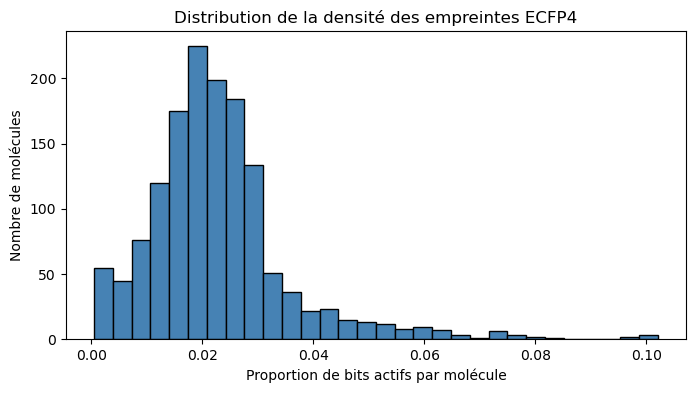

In [43]:
# meta_labels.csv --> lier les fingerprints (X_ECFP4_2048.npy) aux métadonnées
# X_ECFP4_2048.npy --> tableau numpy de taille (n_molecules, 2048) avec n_molecules = 1430
# Matrice d'entrée X  pour ML
X = np.load("data/processed/X_ECFP4_2048.npy")


# Proportion moyenne de bits actifs (1) par molécule
bit_density = X.mean(axis=1)
print("Densité moyenne de bits actifs :", bit_density.mean())

# Taux de bits actifs par position (utile pour visualisation)
bit_freq = X.mean(axis=0)



plt.figure(figsize=(8,4))
plt.hist(bit_density, bins=30, color='steelblue', edgecolor='k')
plt.xlabel("Proportion de bits actifs par molécule")
plt.ylabel("Nombre de molécules")
plt.title("Distribution de la densité des empreintes ECFP4")
plt.show()



# Enrichissement avec les cibles biologiques (ChEMBL) 
--> relier chaque molécule (déjà identifiée dans PubChem par l'InChIKey) à ses cibles biologiques connues (ex. récepteurs dopaminergiques, canaux Na⁺, GABA, etc)

In [44]:
# ============================================================
# ChEMBL  : mapping InChIKey -> molecule_chembl_id
#               + récupération des cibles biologiques
# ============================================================

# Chemins d'entrée/sortie 
DATA_DIR = Path("data/processed")
STRUCT_PATH = DATA_DIR / "labels_neuro_STRICT_with_SMILES_INCHI.csv"  # contient ["stitch_id_flat","inchikey"]

OUT_MAP       = DATA_DIR / "inchikey_to_chembl.csv" # Mapping InChIKey → ChEMBL ID
OUT_TARGETS   = DATA_DIR / "chembl_targets_raw.csv" # Cibles brutes
OUT_ONEHOT    = DATA_DIR / "features_targets_onehot.csv" # Matrice one hot (molécule × cible)

# Requetes HTTP
SESS = requests.Session()
SESS.headers.update({"User-Agent": "NeuroQSAR/1.2 (student project)"})

def _get(url, params=None, timeout=25, tries=3, sleep_s=0.6):
    """GET robuste avec retries."""
    for k in range(tries):
        try:
            r = SESS.get(url, params=params, timeout=timeout)
            if r.status_code == 200:
                return r
        except requests.RequestException:
            pass
        time.sleep(sleep_s * (k+1))
    return None

# Fonction  pour récupèrer les ChEMBL ID associées à un InChIKey

def inchikey_to_chembl(ik: str) -> str | None:
    url = "https://www.ebi.ac.uk/chembl/api/data/molecule.json"
    params = {"molecule_structures__standard_inchi_key": ik}
    r = _get(url, params=params)
    if not r:
        return None
    js = r.json()
    mols = js.get("molecules", [])
    if not mols:
        return None
    return mols[0].get("molecule_chembl_id")


# Fonction pour récupèrer les cibles biologiques associées à un ChEMBL ID

def fetch_targets(chembl_id: str) -> pd.DataFrame:
    url = f"https://www.ebi.ac.uk/chembl/api/data/mechanism.json"
    params = {"molecule_chembl_id": chembl_id, "limit": 100}
    r = _get(url, params=params)
    if not r:
        return pd.DataFrame()
    data = r.json().get("mechanisms", [])
    if not data:
        return pd.DataFrame()
    df = pd.DataFrame(data)
    keep_cols = ["molecule_chembl_id", "target_chembl_id", "target_name", "target_type", "action_type"]
    for c in keep_cols:
        if c not in df.columns:
            df[c] = None
    return df[keep_cols].dropna(subset=["target_chembl_id"])

# Charger les InChIKeys
# on garde que stitch_id_flat, inchikey, on enlève les NaN et doublons par stitch_id_flat

STRUCT = pd.read_csv(STRUCT_PATH, usecols=["stitch_id_flat", "inchikey"]).dropna()
STRUCT = STRUCT.drop_duplicates(subset=["stitch_id_flat"]).reset_index(drop=True)
print(f"[INFO] molécules à mapper (InChIKey→ChEMBL): {len(STRUCT)}")

# Mapping InChIKey → ChEMBL ID
map_rows = []
for i, r in STRUCT.iterrows():
    chembl_id = inchikey_to_chembl(str(r["inchikey"]))
    map_rows.append((r["stitch_id_flat"], r["inchikey"], chembl_id))
    if (i + 1) % 50 == 0:
        print(f"  - mapping progress: {i+1}/{len(STRUCT)}")
        time.sleep(0.2)

MAP = pd.DataFrame(map_rows, columns=["stitch_id_flat", "inchikey", "chembl_id"]).dropna(subset=["chembl_id"])
MAP.to_csv(OUT_MAP, index=False)
print(f"[OK] mapping écrit → {OUT_MAP}  |  rows: {len(MAP)}")

# Récupération des cibles biologiques
targets = []
for i, r in MAP.iterrows():
    df_t = fetch_targets(r["chembl_id"])
    if not df_t.empty:
        df_t["stitch_id_flat"] = r["stitch_id_flat"]
        targets.append(df_t)
    if (i + 1) % 25 == 0:
        print(f"  - targets progress: {i+1}/{len(MAP)}")
        time.sleep(0.25)

if targets:
    TARGETS = pd.concat(targets, ignore_index=True)
else:
    TARGETS = pd.DataFrame(columns=["stitch_id_flat", "target_chembl_id", "target_name", "target_type", "action_type"])

# Nettoyage 
# Supprime les colonnes totalement vides
TARGETS = TARGETS.dropna(axis=1, how="all")

# Supprime les colonnes où toutes les cellules sont vides 
empty_cols = [c for c in TARGETS.columns if TARGETS[c].astype(str).str.strip().eq("").all()]
TARGETS = TARGETS.drop(columns=empty_cols)

# Supprime les doublons
TARGETS = TARGETS.drop_duplicates()

# Sauvegarde du fichier nettoyé
TARGETS.to_csv(OUT_TARGETS, index=False)
print(f"[OK] cibles brutes nettoyées → {OUT_TARGETS}  |  rows: {len(TARGETS)}")
print(f"Colonnes conservées : {list(TARGETS.columns)}")


#  Matrice one-hot (molécule × cible)
if not TARGETS.empty:
    bin_mat = (
        TARGETS.assign(val=1)
        .pivot_table(index="stitch_id_flat",
                     columns="target_chembl_id",
                     values="val",
                     fill_value=0)
        .astype("uint8")
    )
    bin_mat.to_csv(OUT_ONEHOT)
    print(f"[OK] matrice one-hot → {OUT_ONEHOT}  |  shape: {bin_mat.shape}")
else:
    print("[WARN] aucune cible trouvée, matrice vide.")
    pd.DataFrame().to_csv(OUT_ONEHOT, index=False)

# Résumé 
print("\nRésumé ChEMBL")
print(" - Molécules mappées :", len(MAP))
print(" - Paires (molécule–cible) :", len(TARGETS))
if not TARGETS.empty:
    print(" - Cibles distinctes :", TARGETS["target_chembl_id"].nunique())
    print(" - Molécules avec ≥1 cible :", (bin_mat.sum(axis=1) > 0).sum())
else:
    print(" - Aucune cible récupérée.")


[INFO] molécules à mapper (InChIKey→ChEMBL): 1430
  - mapping progress: 50/1430
  - mapping progress: 100/1430
  - mapping progress: 150/1430
  - mapping progress: 200/1430
  - mapping progress: 250/1430
  - mapping progress: 300/1430
  - mapping progress: 350/1430
  - mapping progress: 400/1430
  - mapping progress: 450/1430
  - mapping progress: 500/1430
  - mapping progress: 550/1430
  - mapping progress: 600/1430
  - mapping progress: 650/1430
  - mapping progress: 700/1430
  - mapping progress: 750/1430
  - mapping progress: 800/1430
  - mapping progress: 850/1430
  - mapping progress: 900/1430
  - mapping progress: 950/1430
  - mapping progress: 1000/1430
  - mapping progress: 1050/1430
  - mapping progress: 1100/1430
  - mapping progress: 1150/1430
  - mapping progress: 1200/1430
  - mapping progress: 1250/1430
  - mapping progress: 1300/1430
  - mapping progress: 1350/1430
  - mapping progress: 1400/1430
[OK] mapping écrit → data/processed/inchikey_to_chembl.csv  |  rows: 938
 

Shapes
 - targets: (457, 4)
 - onehot : (320, 202)
 - mapping: (938, 3)

Sanity checks
 - molécules (avec ≥1 cible)           : 320
 - cibles distinctes (colonnes)        : 202
 - sparsité globale (densité moyenne)  : 0.007069925742574258
Colonnes dans targets: ['molecule_chembl_id', 'target_chembl_id', 'action_type', 'stitch_id_flat']


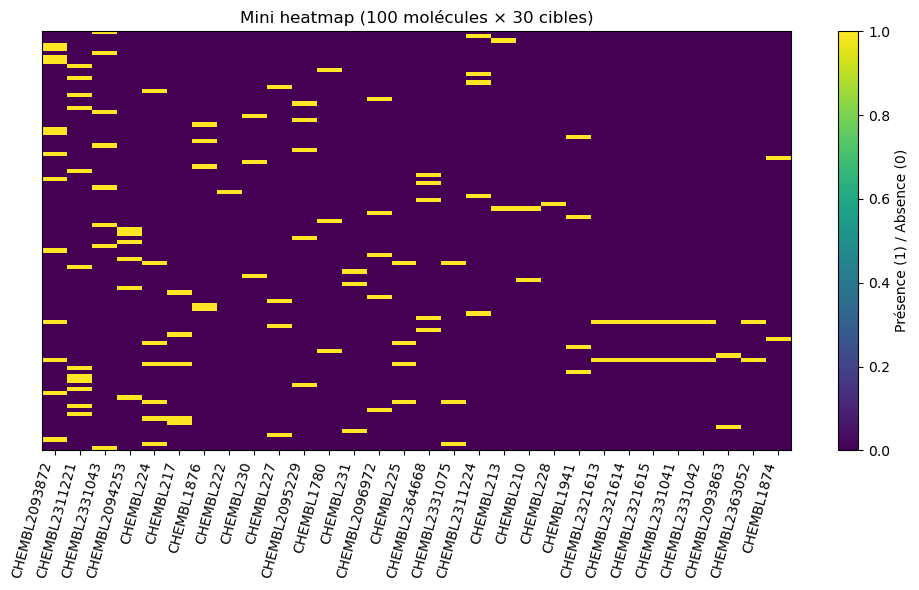

In [ ]:

DATA_DIR = Path("data/processed")

PATH_TARGETS = DATA_DIR / "chembl_targets_raw.csv"         # paires (molécule–cible) "propres"
PATH_ONEHOT  = DATA_DIR / "features_targets_onehot.csv" # matrice binaire (molécule × cible)
PATH_MAP     = DATA_DIR / "inchikey_to_chembl.csv"         # mapping stitch_id_flat ↔ ChEMBL


targets = pd.read_csv(PATH_TARGETS)
onehot  = pd.read_csv(PATH_ONEHOT, index_col=0)

print("Shapes")
print(" - targets:", targets.shape)
print(" - onehot :", onehot.shape)
if PATH_MAP.exists():
    m = pd.read_csv(PATH_MAP)
    print(" - mapping:", m.shape)

print("\nSanity checks")
print(" - molécules (avec ≥1 cible)           :", onehot.shape[0])
print(" - cibles distinctes (colonnes)        :", onehot.shape[1])
print(" - sparsité globale (densité moyenne)  :", onehot.values.mean())

targets_per_mol = onehot.sum(axis=1).sort_values(ascending=False)     # nb de cibles par molécule
freq_per_target = onehot.sum(axis=0).sort_values(ascending=False)     # nb de molécules par cible

print("Colonnes dans targets:", list(targets.columns))  # utile pour debug

# Construire un mapping target_chembl_id → target_name uniquement si la colonne existe ET contient quelque chose
name_map = {}
if {"target_chembl_id", "target_name"}.issubset(targets.columns) and targets["target_name"].notna().any():
    name_map = (
        targets.loc[targets["target_name"].notna(), ["target_chembl_id", "target_name"]]
               .drop_duplicates(subset=["target_chembl_id"])
               .set_index("target_chembl_id")["target_name"]
               .to_dict()
    )

# Helper étiquette : utilise le nom si dispo, sinon l’ID
def label_target(tid: str) -> str:
    nm = name_map.get(tid)
    if not nm or str(nm).strip() == "":
        return tid
    short = nm[:28] + ("…" if len(nm) > 28 else "")
    return f"{tid}\n({short})"

# Helper pour étiquettes lisibles (ID + nom s'il existe)
def label_target(tid: str) -> str:
    nm = name_map.get(tid)
    if pd.isna(nm) or nm is None or str(nm).strip() == "":
        return tid
    return f"{tid}\n({nm[:28]}{'…' if len(nm)>28 else ''})"



#  Heatmap
# On prend les 30 cibles les plus fréquentes × 100 molécules (aléatoires parmi celles qui ont ≥1 cible dans ce sous-ensemble)
cols = freq_per_target.head(30).index
subset = onehot[cols]
rows = subset.index[(subset.sum(axis=1) > 0)]
if len(rows) > 100:
    rows = np.random.choice(rows, size=100, replace=False)
subm = subset.loc[rows]

plt.figure(figsize=(10,6))
plt.imshow(subm.values, aspect="auto", interpolation="nearest")
plt.colorbar(label="Présence (1) / Absence (0)")
plt.yticks([])
plt.xticks(range(subm.shape[1]), [label_target(t) for t in subm.columns], rotation=75, ha="right")
plt.title("Mini heatmap (100 molécules × 30 cibles)")
plt.tight_layout()
plt.show()

In [52]:
# Fusion des données chimiques et biologiques


DATA = Path("data/processed")

# Chargement
meta = pd.read_csv(DATA / "meta_labels.csv")                  
onehot = pd.read_csv(DATA / "features_targets_onehot.csv")  
X = np.load(DATA / "X_ECFP4_2048.npy")                        

# Vérification alignement
print("meta:", meta.shape, "onehot:", onehot.shape, "X:", X.shape)

# Jointure labels ↔ targets
merged = meta.merge(onehot, on="stitch_id_flat", how="left").fillna(0)

# Fusion 
X_df = pd.DataFrame(X, columns=[f"ECFP4_{i}" for i in range(X.shape[1])])
final = pd.concat([merged.reset_index(drop=True), X_df], axis=1)

final.to_csv(DATA / "data_final.csv", index=False) 
print("Dataset final :", final.shape)

meta: (1430, 3) onehot: (320, 203) X: (1430, 2048)
Dataset final : (1430, 2253)


Controle qualité 

Data visualisation

Stats 

Machine Learning 